<a href="https://colab.research.google.com/github/melisailknur/melisailknur/blob/main/Neovision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import pandas as pd
import numpy as np
import glob
import cv2
from tqdm import tqdm
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from google.colab import drive
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from google.colab import drive
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
BATCH_SIZE = 26
IMG_SIZE = 224

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH_TO_PROJECT = "/content/drive/MyDrive/dataset"
PATH_TO_IMAGES = PATH_TO_PROJECT+"/images"
PATH_TO_LABELS = PATH_TO_PROJECT+"/labels.csv"

# Drive

In [ ]:
!ls /content/drive/MyDrive/trash_detection/

ls: cannot access '/content/drive/MyDrive/trash_detection/': No such file or directory


In [ ]:
if not os.path.isdir("/content/sample_data/dataset-original"):
    !unzip /content/drive/MyDrive/trash_detection/dataset-original.zip -d /content/sample_data/

unzip:  cannot find or open /content/drive/MyDrive/trash_detection/dataset-original.zip, /content/drive/MyDrive/trash_detection/dataset-original.zip.zip or /content/drive/MyDrive/trash_detection/dataset-original.zip.ZIP.


# Data preprocessing

In [ ]:
NEW_PATH_TO_IMAGES = PATH_TO_PROJECT+"/images_labels"

In [ ]:
labels = pd.read_csv(PATH_TO_LABELS)
labels["image_name"] = labels["path"].apply(lambda p: p.split('/')[1])

all_images = glob.glob(NEW_PATH_TO_IMAGES+"/*/*.jpg") #fonction glob cherche tous les chemins
if len(all_images) == 0:

    # We will iterate the dataframe label so we can copy only annoated images
    for i, row in tqdm(labels.iterrows()): #tqdm affiche la barre de progression
        img_name = row['image_name']
        label = row['label']

        # Verify if image exist in images folder
        img_path = PATH_TO_IMAGES + '/' + img_name
        if os.path.isfile(img_path) == False:
            continue

        # Create new folder
        new_path_label = NEW_PATH_TO_IMAGES + '/' + label
        os.makedirs(new_path_label, exist_ok=True)

        # Copy image to new folder
        new_path_image = new_path_label + '/' + img_name
        shutil.copy(img_path, new_path_image)
else:
    print("Images already copied !!")

Images already copied !!


In [ ]:
all_images = glob.glob(NEW_PATH_TO_IMAGES+"/*/*.jpg")
labels = pd.read_csv(PATH_TO_LABELS)
len(all_images), len(labels)

(1643, 1643)


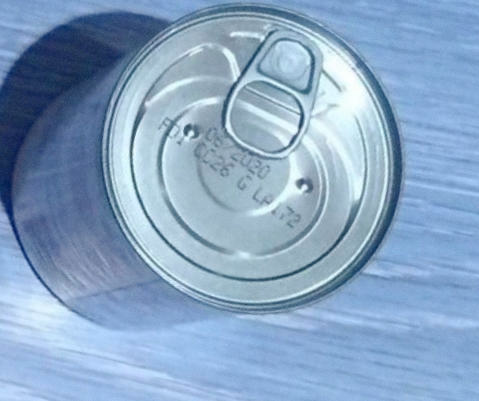

In [ ]:
image_index = 6
img_path = all_images[image_index]
label = img_path.split('/')[-2]
img = cv2.imread(img_path)
px.imshow(img, title=label)

In [ ]:
all_classes = [imgpath.split('/')[-2] for imgpath in all_images]
all_classes_names = list(set(all_classes))
all_classes_count = []
for class_name in all_classes_names:
    all_classes_count.append(all_classes.count(class_name))

In [ ]:
px.bar(x=all_classes_names, y=all_classes_count)

In [ ]:
NUM_CLASSES = len(all_classes_names)
NUM_CLASSES

19

In [ ]:
NEW_PATH_TO_IMAGES

'/content/drive/MyDrive/dataset/images_labels'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  NEW_PATH_TO_IMAGES,
  validation_split=0.2,
  subset="training",
  seed=6,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

Found 1643 files belonging to 19 classes.
Using 1315 files for training.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  NEW_PATH_TO_IMAGES,
  validation_split=0.2,
  subset="validation",
  seed=6,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

Found 1643 files belonging to 19 classes.
Using 328 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['aluminium_foil', 'carton', 'chips_bag', 'drink_carton', 'glass_bottle', 'metal_bottle_cap', 'metal_can', 'paper', 'paper_cup', 'paper_tissues', 'plastic_bag', 'plastic_bottle', 'plastic_bottle_cap', 'plastic_container', 'plastic_cup', 'plastic_lid', 'plastic_straw', 'plastic_tableware', 'styrofoam']


In [ ]:
class_names = test_ds.class_names
print(class_names)

['aluminium_foil', 'carton', 'chips_bag', 'drink_carton', 'glass_bottle', 'metal_bottle_cap', 'metal_can', 'paper', 'paper_cup', 'paper_tissues', 'plastic_bag', 'plastic_bottle', 'plastic_bottle_cap', 'plastic_container', 'plastic_cup', 'plastic_lid', 'plastic_straw', 'plastic_tableware', 'styrofoam']


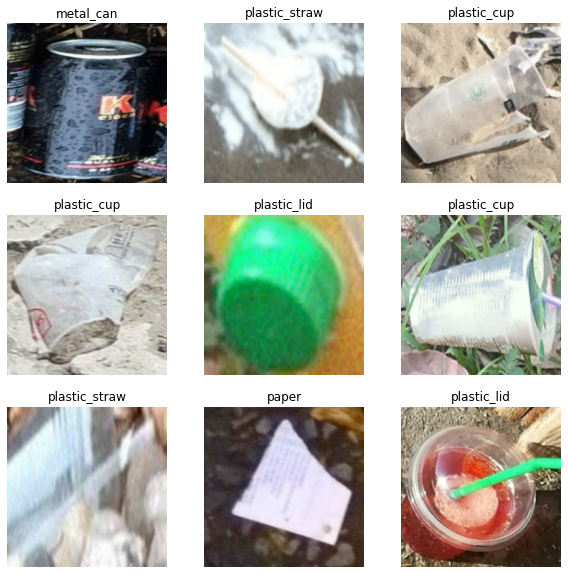

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

#fonction map pour appliquer une transformation à tous les éléments d'une liste
train_ds = train_ds.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
#train_ds = train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(input_preprocess)
#test_ds = test_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)

# Model training

In [ ]:
#train_ds.__len__()
sum(train_ds.map(lambda x,y: 1).as_numpy_iterator())

51

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()


Not connected to a TPU runtime. Using CPU/GPU strategy


In [ ]:
with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #x = img_augmentation(inputs)
    outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs) #(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 19)               4073910   
                                                                 
Total params: 4,073,910
Trainable params: 4,031,887
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
epochs = 5
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)

Epoch 1/5
51/51 - 478s - loss: 3.9063 - accuracy: 0.1300 - val_loss: 2.8160 - val_accuracy: 0.1220 - 478s/epoch - 9s/step
Epoch 2/5
51/51 - 399s - loss: 3.3566 - accuracy: 0.1703 - val_loss: 2.8305 - val_accuracy: 0.1768 - 399s/epoch - 8s/step
Epoch 3/5
51/51 - 394s - loss: 3.1003 - accuracy: 0.1665 - val_loss: 2.7998 - val_accuracy: 0.1768 - 394s/epoch - 8s/step
Epoch 4/5
51/51 - 369s - loss: 2.9425 - accuracy: 0.2046 - val_loss: 2.8124 - val_accuracy: 0.1768 - 369s/epoch - 7s/step
Epoch 5/5
51/51 - 366s - loss: 2.8032 - accuracy: 0.2281 - val_loss: 2.8748 - val_accuracy: 0.1768 - 366s/epoch - 7s/step


In [ ]:
conf = tf.confusion_matrix(labels=label, predictions=)
conf

AttributeError: ignored

# Model evaluation

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()